# Install Dependendcies

In [ ]:
!pip3 install transformers

     |████████████████████████████████| 3.5 MB 7.3 MB/s 
     |████████████████████████████████| 6.5 MB 57.2 MB/s 
     |████████████████████████████████| 67 kB 6.0 MB/s 
     |████████████████████████████████| 895 kB 49.2 MB/s 
     |████████████████████████████████| 596 kB 21.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!nvidia-smi

Wed Mar  2 21:51:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# from google.colab import drive 
# drive.mount('/content/gdrive')
# !ln -s /content/gdrive/My\ Drive/ /mydrive
# !ls /mydrive

# Download the Dataset

In [ ]:
!gdown --id 1-n9aJG1zdWHL0UjuRWwa8Rro-ogoWxN7
!unzip deception_dataset.zip && rm deception_dataset.zip && rm -r __MACOSX

# Data Helpers

In [ ]:
import numpy as np
import string
import os
import io
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

SEQUENCE_LEN = 200


def read_from_dir(in_fold_dir):
    reviews = []
    for filename in os.listdir(in_fold_dir):
        if filename.endswith(".txt"):
            # read from file containing the text review
            in_filepath = in_fold_dir + filename
            with io.open(in_filepath, 'r', encoding='windows-1252') as f:
                review = f.read()
                # if len(review) > SEQUENCE_LEN:
                #     review = review[:200]
                reviews.append(review)    

    # print("number of reviews: {}, name: {}".format(len(reviews), in_fold_dir)) 
    print(reviews[:2])         
    return reviews


def load_data():
    trustworthy_hotel_positive = read_from_dir('deception_dataset/hotel/positive/truthful/') 
    trustworthy_hotel_negative = read_from_dir('deception_dataset/hotel/negative/truthful/')
    trustworthy_restaurant = read_from_dir('deception_dataset/restaurant/truthful/')
    trustworthy_doctor = read_from_dir('deception_dataset/doctor/truthful/')[:200]

    untrustworthy_hotel_positive = read_from_dir('deception_dataset/hotel/positive/deceptive_turker/')
    untrustworthy_hotel_negative = read_from_dir('deception_dataset/hotel/negative/deceptive_turker/') 
    untrustworthy_hotel_expert_positive =  read_from_dir('deception_dataset/hotel/positive/deceptive_expert/')
    untrustworthy_hotel_expert_negative =  read_from_dir('deception_dataset/hotel/negative/deceptive_expert/')
    
    untrustworthy_restaurant = read_from_dir('deception_dataset/restaurant/deceptive_MTurk/')[:200]
    untrustworthy_doctor = read_from_dir('deception_dataset/doctor/deceptive_MTurk/')

    TRUSTWORTHY_REVIEWS_DICT = {}
    UNTRUSTWORTHY_REVIEWS_DICT = {}

    TRUSTWORTHY_REVIEWS_DICT["cross_domain"] = {
        "hotel":trustworthy_hotel_positive + trustworthy_hotel_negative,
        "restaurant":trustworthy_restaurant,
        "doctor":trustworthy_doctor
    }

    UNTRUSTWORTHY_REVIEWS_DICT["cross_domain"] = { 
        "hotel":untrustworthy_hotel_positive + untrustworthy_hotel_negative,
        "restaurant":untrustworthy_restaurant,
        "doctor":untrustworthy_doctor[:200]
    }

    TRUSTWORTHY_REVIEWS_DICT["mixed_domain"] = {
        "hotel":trustworthy_hotel_positive + trustworthy_hotel_negative,
        "restaurant":trustworthy_restaurant,
        "doctor":trustworthy_doctor
    }

    UNTRUSTWORTHY_REVIEWS_DICT["mixed_domain"] = { 
        "hotel":untrustworthy_hotel_positive + untrustworthy_hotel_expert_positive + untrustworthy_hotel_negative + untrustworthy_hotel_expert_negative,
        "restaurant":untrustworthy_restaurant,
        "doctor":untrustworthy_doctor
    }

    return TRUSTWORTHY_REVIEWS_DICT, UNTRUSTWORTHY_REVIEWS_DICT


TRUSTWORTHY_REVIEWS_DICT, UNTRUSTWORTHY_REVIEWS_DICT = load_data()

['I booked this hotel for $75 on Hotwire with mid-level expectations for one night. Totally blown away. Arrived on a Sunday night. Gave car to valet ($51/night). Lobby was a social people watching scene with swank music. Check-in was smooth and easy. I asked for an upgrade and was told no free upgrades to 3rd party bookings. Upgrade to suite was available at a cost. I passed since only 1 night stay. I asked for a nice, quiet room away from noisy housekeeping and ice machine. Received room 10-120. Room was huge with 2 beds. Felt like 400 square feet. Newly renovated last year. Bell hop told me some rooms are very small so I totally lucked out! Service from start to finish was top notch. Everyone had a smile on their face. Always spoke with great respect and made us feel welcome. Ordered room service at 10:45 PM. Arrived in 1/2 hour. food was so-so. Had pancakes in Lockwood for breakfast. Very good food and very good service. Strong coffee. Hotel is right on State Street shopping. FYI - 

In [ ]:
def get_reviews_from_dict(reviews_dict, keys = []):
    if not keys:
        raise Exception("Invalid key: key must be one of the following: \'hotel\', \'restaurant\', \'doctor\'")

    reviews = []
    for key in keys:
        if key in reviews_dict:
            reviews += reviews_dict[key]
        else:
            raise Exception("Invalid key: key must be one of the following: \'hotel\', \'restaurant\', \'doctor\'")
    return reviews

def get_reviews(review_type="", keys = [], data_name="cross_domain"):
    if not review_type:
        raise Exception("Invalid review_type: review_type must be either \'trustworthy\' or \'untrustworthy\'.")
    if not keys:
        raise Exception("Invalid key: key must be one of the follwowing: \'hotel\', \'restaurant\', \'doctor\'")

    if review_type=="trustworthy":
        return get_reviews_from_dict(reviews_dict=TRUSTWORTHY_REVIEWS_DICT[data_name], keys=keys)
    elif review_type=="untrustworthy":
        return get_reviews_from_dict(reviews_dict=UNTRUSTWORTHY_REVIEWS_DICT[data_name], keys=keys)
    else:
        raise Exception("Invalid review_type: review_type must be either \'trustworthy\' or \'untrustworthy\'.")


def get_data(keys=[], data_name="cross_domain"):
    if data_name != "cross_domain" and data_name != "mixed_domain":
        raise Exception("Invalid dataset name")

    trustworthy_reviews   = get_reviews(review_type="trustworthy", keys=keys, data_name=data_name)
    untrustworthy_reviews = get_reviews(review_type="untrustworthy", keys=keys, data_name=data_name)
    
    reviews = trustworthy_reviews + untrustworthy_reviews

    # generate labels
    labels_trustworthy   = [[1,0] for _ in range(len(trustworthy_reviews   ))]
    labels_untrustworthy = [[0,1] for _ in range(len(untrustworthy_reviews ))]
    labels = labels_trustworthy + labels_untrustworthy

    print("dataset_name: {}".format(data_name+"_"+keys[0]))
    print("trustworthy_reviews: {}".format(len(trustworthy_reviews)))
    print("untrustworthy_reviews: {}".format(len(untrustworthy_reviews)))
    print("reviews len: ", len(reviews))
    print("labels len: ", len(labels))
    print()
        
    return reviews, labels

In [ ]:
import numpy as np
import os
import re
import itertools
import scipy.sparse as sp
from collections import Counter
import torch


SEQUENCE_LEN = 200


def build_vocab(sentences, vocab_size=50000):
    word_counts = Counter(itertools.chain(*sentences)) 
    vocabulary_inv = [x[0] for x in word_counts.most_common(vocab_size)]
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    # append <UNK/> symbol to the vocabulary
    vocabulary['<UNK/>'] = len(vocabulary)
    vocabulary_inv.append('<UNK/>')
    return [vocabulary, vocabulary_inv]


def build_input_data(sentences, vocabulary):
    x = np.array([[vocabulary[word] if word in vocabulary else vocabulary['<UNK/>'] for word in sentence] for sentence in sentences])
    return x


def load_data(fold = 1, vocab_size=30001):
    # Load data
    trustworthy_reviews_for_training, trustworthy_reviews_for_testing, untrustworthy_reviews_for_training, untrustworthy_reviews_for_testing = data.load_data(fold=fold)
    train = trustworthy_reviews_for_training + untrustworthy_reviews_for_training
    test  = trustworthy_reviews_for_testing + untrustworthy_reviews_for_testing

    # generate labels
    train_labels1 = [[1,0] for _ in range(len(trustworthy_reviews_for_training   ))]
    train_labels0 = [[0,1] for _ in range(len(untrustworthy_reviews_for_training ))]
    test_labels1  = [[1,0] for _ in range(len(trustworthy_reviews_for_testing    ))]
    test_labels0  = [[0,1] for _ in range(len(untrustworthy_reviews_for_testing  ))]

    train_labels = np.concatenate((np.array(train_labels1), np.array(train_labels0)), axis=0)
    test_labels  = np.concatenate((np.array(test_labels1),  np.array(test_labels0)),  axis=0)

    # convert word2idx
    vocabulary, vocabulary_inv = build_vocab(train + test, vocab_size=vocab_size)
    train = build_input_data(train, vocabulary)
    test  = build_input_data(test,   vocabulary)
    
    return train, train_labels, train_labels, train, test_labels, test_labels, vocabulary, vocabulary_inv


def batch_iter(data, batch_size, num_epochs):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int(len(data)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_data = data[shuffle_indices]
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [ ]:
# def get_cross_domain_dataset(test_keys=[]):
#     train_keys = ["hotel"]

#     train_reviews, train_labels = get_data(keys=train_keys, data_name="cross_domain")
#     test_reviews,  test_labels  = get_data(keys=test_keys, data_name="cross_domain")
#     all_reviews = train_reviews + test_reviews
    
#     return train_reviews, train_labels, test_reviews, test_labels

# def get_cross_domain_dataset_restaurant():
#     return get_cross_domain_dataset(test_keys=["restaurant"])

# def get_cross_domain_dataset_doctor():
#     return get_cross_domain_dataset(test_keys=["doctor"])

In [ ]:
def get_mix_domain_dataset(fold=1):
    keys = ["hotel", "restaurant", "doctor"]
    data, labels = get_data(keys=keys, data_name="mixed_domain")

    MAX_FOLD = 5
    LEN_DATA = len(data)
    DELTA = int(LEN_DATA / MAX_FOLD)
    start_idx = (fold-1)*DELTA
    end_idx   = start_idx + DELTA

    # print("HERE", data[0:start_idx])

    train_reviews = data[0:start_idx]
    train_reviews.extend(data[end_idx:])

    train_labels = labels[0:start_idx]
    train_labels.extend(labels[end_idx:])

    test_reviews   = data[start_idx:end_idx]
    test_labels = labels[start_idx:end_idx]

    return train_reviews, train_labels, test_reviews, test_labels

# Review Dataset

In [ ]:
import torch

class UntrustworthyReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_data, train_labels, test_data, test_labels = get_mix_domain_dataset(fold=1)

print("mixed_domain_dataset train: ", len(train_data))
print("mixed_domain_dataset test: ", len(test_data))

print(type(train_data))
print(type(test_data))
print(type(train_labels))
print(type(test_labels))

dataset_name: mixed_domain_hotel
trustworthy_reviews: 1200
untrustworthy_reviews: 1637
reviews len:  2837
labels len:  2837

mixed_domain_dataset train:  2270
mixed_domain_dataset test:  567
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


# Hyperparameters

In [ ]:
import torch.nn as nn

FOLD = 5
BATCH_SIZE = 16 # 48
LR = 1e-3
EPOCHS = 5
cross_entropy = nn.NLLLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

target_names = ["trustworthy", "untrustworthy"]

# Define Transformer-based Architecture for Fine-tuning

In [ ]:
class TransformerArchitecture(nn.Module):

    def __init__(self, bert):
      
      super(TransformerArchitecture, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768, 512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512, 2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, input_ids, attention_mask):

      #pass the inputs to the model  
      x = self.bert(input_ids, attention_mask=attention_mask)
      # print(x[0])
      
      x = self.fc1(x[0])

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x



# Define Training Method

In [ ]:
# function to train the model
def train(model, train_dataloader, optimizer):
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds, total_labels = [], []
  
  # iterate over batches
  for step, batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    input_ids      = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels         = batch['labels'].to(device)

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(input_ids, attention_mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # print('train_loss ', loss.item())

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # ADDED

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds = preds.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)
    total_labels.append(labels)
    
  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  # print("train loss: ", avg_loss)

  
  # predictions are in the form of (no. of batches, size of batch, no. of cla
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds   = np.concatenate(total_preds, axis=0)
  total_labels  = np.concatenate(total_labels, axis=0)
  

  #returns the loss and predictions
  return avg_loss, total_preds, total_labels

# Define Evaluating Method

In [ ]:
def evaluate(model, valid_dataloader):
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds, total_labels = [], []

  # iterate over batches
  for step, batch in enumerate(valid_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(valid_dataloader)))

    # push the batch to gpu
    input_ids      = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels         = batch['labels'].to(device)

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(input_ids, attention_mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds, labels)

      total_loss = total_loss + loss.item()
      # print('valid_loss ', loss.item())

      # model predictions are stored on GPU. So, push it to CPU
      preds = preds.detach().cpu().numpy()
      labels = labels.detach().cpu().numpy()

      # append the model predictions
      total_preds.append(preds)
      total_labels.append(labels)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(valid_dataloader) 
  # print("eval loss: ", avg_loss)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  total_labels  = np.concatenate(total_labels, axis=0)

  return avg_loss, total_preds, total_labels

# Train and Validate

In [ ]:
from sklearn.metrics import classification_report


def train_and_validate(model, model_name, train_dataloader, valid_dataloader, optimizer, fold):
  best_valid_loss = 30

  # set initial loss to infinite
  best_valid_loss = float('inf')
  best_accuracy = 0 

  # empty lists to store training and validation loss of each epoch
  train_losses=[]
  valid_losses=[]
  for epoch in range(EPOCHS):
      print('\n Epoch {:} / {:}'.format(epoch + 1, EPOCHS))
      
      # train model
      train_loss, train_preds, train_labels = train(model, train_dataloader, optimizer)
      
      # evaluate model
      valid_loss, valid_preds, valid_labels = evaluate(model, valid_dataloader)
      
      # append training and validation loss
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
      
      print(f'\nTraining Loss: {train_loss:.3f}')
      print(f'Validation Loss: {valid_loss:.3f}')
     
      train_labels = np.argmax(train_labels, axis = 1)
      train_preds = np.argmax(np.argmax(train_preds, axis = 1), axis=1) # inner argmax try softmax
      train_report = classification_report(train_labels, train_preds, target_names=target_names, output_dict=True)
      add(train_report, report, stage='train', metrics=metrics, model_name=model_name, fold=fold)

      valid_labels = np.argmax(valid_labels, axis = 1)
      valid_preds = np.argmax(np.argmax(valid_preds, axis = 1), axis=1)
      valid_report = classification_report(valid_labels, valid_preds, target_names=target_names, output_dict=True)
      add(valid_report, report, stage='valid', metrics=metrics, model_name=model_name, fold=fold)

      # print the best results for a given model (and save its weights)
      current_accuracy = 0
      for metric in metrics:
        if metric == "accuracy":
          current_accuracy += valid_report[metric]
        else:
          current_accuracy += valid_report['macro avg'][metric]

      if best_accuracy < current_accuracy:
        best_accuracy = current_accuracy
        print('Best Accuracy for the model {:} at {:} epoch'.format(model_name, epoch + 1))
        print(valid_report)
        # torch.save(model.state_dict(), model_name + '-best.pt')

      # if valid_loss < best_valid_loss:
      #     best_valid_loss = valid_loss
      #     torch.save(model.state_dict(), 'best.pt')

  return report

In [ ]:
def freeze_parameters(transformer_model):
  # freeze all the parameters
  for param in transformer_model.parameters():
      param.requires_grad = False

In [ ]:
from transformers import AutoModel
from transformers import AutoTokenizer
from torch.optim import AdamW


def train_and_evaluate(model_name, fold):
  transformer_model = AutoModel.from_pretrained(model_name)
  freeze_parameters(transformer_model)

  # Extend the model for fine-tuning
  model_architecture = TransformerArchitecture(transformer_model)
  model_architecture.to(device)

  optimizer = AdamW(model_architecture.parameters(), lr = LR)

  tokenizer = AutoTokenizer.from_pretrained(model_name)     

  train_data, train_labels, test_data, test_labels = get_mix_domain_dataset(fold)

  train_encodings  = tokenizer(train_data, truncation=True, padding=True)
  test_encodings   = tokenizer(test_data, truncation=True, padding=True)

  train_dataset    = UntrustworthyReviewDataset(train_encodings, train_labels)
  valid_dataset    = UntrustworthyReviewDataset(test_encodings, test_labels)

  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  valid_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

  report = train_and_validate(model_architecture, model_name, train_dataloader, valid_dataloader, optimizer, fold)
  
  return report

# Plotting Methods

In [ ]:
from matplotlib import pyplot


def initialize_report(stages=['train', 'valid'], metrics=['precision', 'recall', 'f1-score', 'accuracy'], model_names=[]):
  report = {}
  for model_name in model_names:
    report[model_name] = {}
    for stage in stages:
        report[model_name][stage] = {}
        for fold in range(1, FOLD+1):
          report[model_name][stage][fold] = {}
          for metric in metrics:
              report[model_name][stage][fold][metric] = []

  return report


def add(cls_report, report, stage, metrics, model_name, fold):
  metrics = ['precision', 'recall', 'f1-score', 'accuracy']
  for metric in metrics:
    if metric == "accuracy":
      report[model_name][stage][fold][metric].append(cls_report[metric])
    else:
      report[model_name][stage][fold][metric].append(cls_report['weighted avg'][metric])


def plot_results(report, stages, metrics, model_names):
  for stage in stages:
    pyplot.subplot(212)
    for metric in metrics:
      pyplot.title(stage + ' ' + metric)
      for model_name in model_names:
        pyplot.xlabel('epochs')
        pyplot.ylabel(metric) 

        eval_metric = report[model_name][stage][0][metric]
        epochs = [(i+1) for i in range(len(eval_metric))]

        pyplot.plot(epochs, eval_metric, label=model_name, 
                    marker='o', linestyle='--')
        
      pyplot.legend()
      pyplot.show()

In [ ]:
def avg_over_folds(report, stages=['train', 'valid'], metrics=['precision', 'recall', 'f1-score', 'accuracy'], model_names=[]): 
  for model_name in model_names:
    for stage in stages:
      report[model_name][stage][0] = {} 
      for metric in metrics:
        
        avgs = []
        for epoch in range(EPOCHS):
          avg = 0
          for fold in range(1, FOLD+1):
            avg += report[model_name][stage][fold][metric][epoch] 
          avg = avg/float(FOLD)
          avgs.append(avg)

        report[model_name][stage][0][metric] = avgs

# Print Best Report Method

In [ ]:
# import pandas as pd

# def print_report(report, stages=['train', 'valid'], metrics=['precision', 'recall', 'f1-score', 'accuracy'], model_names=[]):
#   for stage in ['eval']:
#     best_report = None
#     best_result = []
#     for model_name in model_names:
      
#       # identify best report
#       model_best_result = []
#       model_best_accuracy = 0
#       for epoch in EPOCHS:
        
#         current_accuracy = 0
#         for epoch in EPOCHS:
#           if metric == "accuracy":
#               current_accuracy += report[model_name][stage][0][metric][epoch]
#           else:
#               current_accuracy += report[model_name][stage][0][metric]['weighted avg'][metric][epoch]

#         if model_best_accuracy < current_accuracy:
#           current_accuracy = model_best_accuracy
#           model_best_epoch = epoch
#           model_best_result = []
#           for metric in metrics:
#             model_best_result.append(report[model_name][stage][0][metric][epoch])  
       
#        best_result.append([model_name].append(model_best_result))     


#     print( pd.DataFrame(best_result, columns=['model_name'].append(metrics)) )
#     print()

# Run the Experiment

In [ ]:
stages = ['train', 'valid']
metrics = ['precision', 'recall', 'f1-score', 'accuracy']
model_names = ['bert-base-uncased', 'roberta-base', 'microsoft/deberta-base', 'funnel-transformer/medium-base']
model_names = ['microsoft/deberta-base']


report = initialize_report(stages=['train', 'valid'], metrics=['precision', 'recall', 'f1-score', 'accuracy'], model_names=model_names)
print(report)


for model_name in model_names:
  for fold in range(1, FOLD+1):
    train_and_evaluate(model_name, fold)

{'microsoft/deberta-base': {'train': {1: {'precision': [], 'recall': [], 'f1-score': [], 'accuracy': []}, 2: {'precision': [], 'recall': [], 'f1-score': [], 'accuracy': []}, 3: {'precision': [], 'recall': [], 'f1-score': [], 'accuracy': []}, 4: {'precision': [], 'recall': [], 'f1-score': [], 'accuracy': []}, 5: {'precision': [], 'recall': [], 'f1-score': [], 'accuracy': []}}, 'valid': {1: {'precision': [], 'recall': [], 'f1-score': [], 'accuracy': []}, 2: {'precision': [], 'recall': [], 'f1-score': [], 'accuracy': []}, 3: {'precision': [], 'recall': [], 'f1-score': [], 'accuracy': []}, 4: {'precision': [], 'recall': [], 'f1-score': [], 'accuracy': []}, 5: {'precision': [], 'recall': [], 'f1-score': [], 'accuracy': []}}}}


Downloading:   0%|          | 0.00/474 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/533M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

dataset_name: mixed_domain_hotel
trustworthy_reviews: 1200
untrustworthy_reviews: 1637
reviews len:  2837
labels len:  2837


 Epoch 1 / 5
  Batch    50  of    142.
  Batch   100  of    142.

Evaluating...
  Batch    50  of    142.
  Batch   100  of    142.

Training Loss: 0.847
Validation Loss: 0.446
Best Accuracy for the model microsoft/deberta-base at 1 epoch
{'trustworthy': {'precision': 0.7232704402515723, 'recall': 0.5450236966824644, 'f1-score': 0.6216216216216217, 'support': 633}, 'untrustworthy': {'precision': 0.8393753485778026, 'recall': 0.9193646915088577, 'f1-score': 0.8775510204081634, 'support': 1637}, 'accuracy': 0.8149779735682819, 'macro avg': {'precision': 0.7813228944146875, 'recall': 0.7321941940956611, 'f1-score': 0.7495863210148925, 'support': 2270}, 'weighted avg': {'precision': 0.8069989578418978, 'recall': 0.8149779735682819, 'f1-score': 0.8061839237421365, 'support': 2270}}

 Epoch 2 / 5
  Batch    50  of    142.
  Batch   100  of    142.

Evaluating...
  Bat

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


dataset_name: mixed_domain_hotel
trustworthy_reviews: 1200
untrustworthy_reviews: 1637
reviews len:  2837
labels len:  2837


 Epoch 1 / 5
  Batch    50  of    142.
  Batch   100  of    142.

Evaluating...
  Batch    50  of    142.
  Batch   100  of    142.

Training Loss: 0.826
Validation Loss: 0.426
Best Accuracy for the model microsoft/deberta-base at 1 epoch
{'trustworthy': {'precision': 0.6672158154859967, 'recall': 0.6398104265402843, 'f1-score': 0.6532258064516129, 'support': 633}, 'untrustworthy': {'precision': 0.8628983764281419, 'recall': 0.8766035430665852, 'f1-score': 0.8696969696969696, 'support': 1637}, 'accuracy': 0.8105726872246696, 'macro avg': {'precision': 0.7650570959570693, 'recall': 0.7582069848034347, 'f1-score': 0.7614613880742913, 'support': 2270}, 'weighted avg': {'precision': 0.8083313891698257, 'recall': 0.8105726872246696, 'f1-score': 0.8093329845276697, 'support': 2270}}

 Epoch 2 / 5
  Batch    50  of    142.
  Batch   100  of    142.

Evaluating...
  Bat

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


dataset_name: mixed_domain_hotel
trustworthy_reviews: 1200
untrustworthy_reviews: 1637
reviews len:  2837
labels len:  2837


 Epoch 1 / 5
  Batch    50  of    142.
  Batch   100  of    142.

Evaluating...
  Batch    50  of    142.
  Batch   100  of    142.

Training Loss: 0.917
Validation Loss: 0.563
Best Accuracy for the model microsoft/deberta-base at 1 epoch
{'trustworthy': {'precision': 0.8353080568720379, 'recall': 0.6216931216931217, 'f1-score': 0.7128412537917088, 'support': 1134}, 'untrustworthy': {'precision': 0.6991584852734923, 'recall': 0.8776408450704225, 'f1-score': 0.7782982045277127, 'support': 1136}, 'accuracy': 0.7497797356828194, 'macro avg': {'precision': 0.7672332710727652, 'recall': 0.7496669833817722, 'f1-score': 0.7455697291597108, 'support': 2270}, 'weighted avg': {'precision': 0.7671732932879199, 'recall': 0.7497797356828194, 'f1-score': 0.745598564820828, 'support': 2270}}

 Epoch 2 / 5
  Batch    50  of    142.
  Batch   100  of    142.

Evaluating...
  Bat

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


dataset_name: mixed_domain_hotel
trustworthy_reviews: 1200
untrustworthy_reviews: 1637
reviews len:  2837
labels len:  2837


 Epoch 1 / 5
  Batch    50  of    142.
  Batch   100  of    142.

Evaluating...
  Batch    50  of    142.
  Batch   100  of    142.

Training Loss: 0.905
Validation Loss: 0.721
Best Accuracy for the model microsoft/deberta-base at 1 epoch
{'trustworthy': {'precision': 0.9225908372827805, 'recall': 0.4866666666666667, 'f1-score': 0.6372067648663393, 'support': 1200}, 'untrustworthy': {'precision': 0.6237018937080024, 'recall': 0.9542056074766355, 'f1-score': 0.754340598448467, 'support': 1070}, 'accuracy': 0.7070484581497798, 'macro avg': {'precision': 0.7731463654953914, 'recall': 0.7204361370716511, 'f1-score': 0.6957736816574032, 'support': 2270}, 'weighted avg': {'precision': 0.7817048594744049, 'recall': 0.7070484581497798, 'f1-score': 0.6924196291539502, 'support': 2270}}

 Epoch 2 / 5
  Batch    50  of    142.
  Batch   100  of    142.

Evaluating...
  Bat

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


dataset_name: mixed_domain_hotel
trustworthy_reviews: 1200
untrustworthy_reviews: 1637
reviews len:  2837
labels len:  2837


 Epoch 1 / 5
  Batch    50  of    142.
  Batch   100  of    142.

Evaluating...
  Batch    50  of    142.
  Batch   100  of    142.

Training Loss: 0.914
Validation Loss: 0.525
Best Accuracy for the model microsoft/deberta-base at 1 epoch
{'trustworthy': {'precision': 0.8524064171122995, 'recall': 0.6641666666666667, 'f1-score': 0.7466042154566745, 'support': 1200}, 'untrustworthy': {'precision': 0.69812734082397, 'recall': 0.8710280373831776, 'f1-score': 0.775051975051975, 'support': 1070}, 'accuracy': 0.7616740088105727, 'macro avg': {'precision': 0.7752668789681347, 'recall': 0.7675973520249222, 'f1-score': 0.7608280952543247, 'support': 2270}, 'weighted avg': {'precision': 0.7796845617693424, 'recall': 0.7616740088105727, 'f1-score': 0.7600135118297897, 'support': 2270}}

 Epoch 2 / 5
  Batch    50  of    142.
  Batch   100  of    142.

Evaluating...
  Batch

# Plot Results

In [ ]:
report

{'microsoft/deberta-base': {'train': {1: {'accuracy': [0.7220264317180617,
     0.7832599118942731,
     0.811453744493392,
     0.826431718061674,
     0.8458149779735683],
    'f1-score': [0.7214123172962528,
     0.7842792208089432,
     0.8110840276865424,
     0.8245530268669432,
     0.8456647003196293],
    'precision': [0.7208211979340159,
     0.7854280833888917,
     0.8107366442162205,
     0.8233240668575119,
     0.8455203899818522],
    'recall': [0.7220264317180617,
     0.7832599118942731,
     0.811453744493392,
     0.826431718061674,
     0.8458149779735683]},
   2: {'accuracy': [0.7251101321585903,
     0.792511013215859,
     0.8118942731277533,
     0.8352422907488987,
     0.8488986784140969],
    'f1-score': [0.724571105785987,
     0.7926611227288376,
     0.8115720035923764,
     0.8340776666833646,
     0.8471385946027346],
    'precision': [0.7240503868350227,
     0.7928142308217032,
     0.8112668383811621,
     0.8332042152466661,
     0.8461617570388745]

In [ ]:
avg_over_folds(report, stages, metrics, model_names) 

In [ ]:
report

{'microsoft/deberta-base': {'train': {0: {'accuracy': [0.6910132158590309,
     0.7782378854625551,
     0.7971806167400881,
     0.8080176211453745,
     0.8322466960352424],
    'f1-score': [0.6827925196235252,
     0.7774993074987283,
     0.7965965696855186,
     0.8070347931510551,
     0.8316234778776392],
    'precision': [0.7023081629225416,
     0.7809927613965562,
     0.7978244707961475,
     0.8077329569305688,
     0.8322749314371374],
    'recall': [0.6910132158590309,
     0.7782378854625551,
     0.7971806167400881,
     0.8080176211453745,
     0.8322466960352424]},
   1: {'accuracy': [0.7220264317180617,
     0.7832599118942731,
     0.811453744493392,
     0.826431718061674,
     0.8458149779735683],
    'f1-score': [0.7214123172962528,
     0.7842792208089432,
     0.8110840276865424,
     0.8245530268669432,
     0.8456647003196293],
    'precision': [0.7208211979340159,
     0.7854280833888917,
     0.8107366442162205,
     0.8233240668575119,
     0.8455203899818

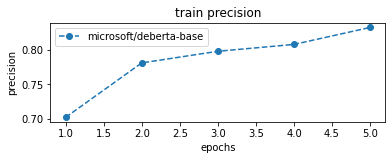

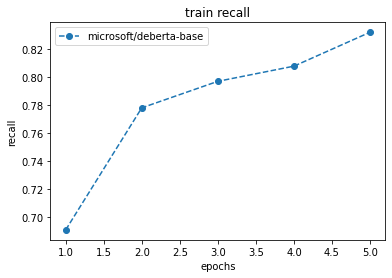

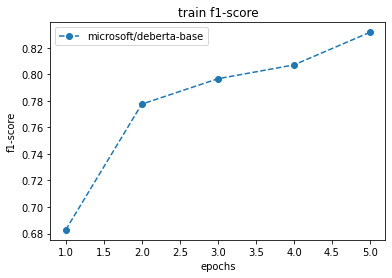

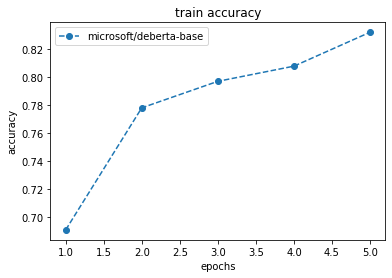

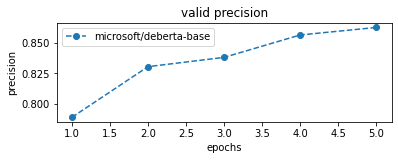

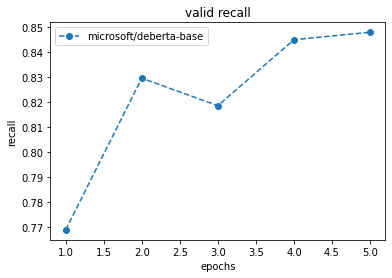

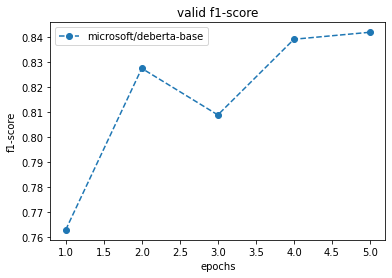

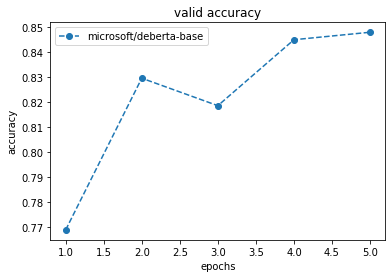

In [ ]:
plot_results(report, stages, metrics, model_names)